1) посмотреть, где ошибается классификатор

2) тюнить параметры

3) важность признаков +

4) переразметить некоторые документы +

5) кривая обучения

6) несколько признаков с разным распознаванием жирности

7) средний цвет для распознавания жирности

8) является ли предыдущая строка продолжением следующей


In [17]:
import re
import cv2
import json
import numpy as np
from functools import reduce
from sklearn.pipeline import make_pipeline, FeatureUnion
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from tqdm import tqdm_notebook as tqdm
import matplotlib.pyplot as plt
from collections import defaultdict
import xgbfir
from itertools import product
from sklearn.utils import shuffle

In [4]:
reg_expr = [re.compile(r'\d+(\.\d+)+\D'), # 1.1.1 1
            re.compile(r'\d+[\)\}]'), # 1) 2
            re.compile(r'\w+(\.\w+)+\W'), # 3
            re.compile(r'[а-яА-Я\d]+(\.[а-яА-Я\d]+)+\W'), # b.b.b 4
            re.compile(r'[\wа-яА-Я]\.\W'), # b. 5
            re.compile(r'[6а-яА-Яa-zA-Z][\)\}]'), # б) 6
            re.compile(r'\-|—'), # - 7
            re.compile(r'®|\*'), # * 8
            re.compile(r'[a-zа-я]'), # строчная буква в начале 9
            re.compile(r'[A-ZА-Я]'),  # заглавная буква в начале 10
            re.compile(r'Раздел|Подраздел|Глава|Параграф|Секция|Часть|Статья')] # 11

def add_reg_features(line):
    features = [0] * len(reg_expr)
    i = 0
    for expr in reg_expr:
        match = expr.search(line)
    
        if match:
            if match.start() == 0:
                features[i] = 1
        i += 1
        
    return features

In [5]:
end_reg_expr = [re.compile(r'.*\.'),
                re.compile(r'.*;'),
                re.compile(r'.*:'),
                re.compile(r'.*,'),
                re.compile(r'.*[\wа-яА-Я]')]

def add_end_reg_features(line):
    features = [0] * len(end_reg_expr)
    i = 0
    for expr in end_reg_expr:
        match = expr.fullmatch(line)
        if match:
            features[i] = 1
        i += 1
    return features

In [6]:
def mean_bbox_size(bboxes):
    """
    bboxes - list [{"text": "", "bbox": []}, {} ...]
    returns (mean_height, mean_width)
    """
    lefts = np.sum(list(map(lambda x: x['bbox'][0], bboxes)))
    widths = np.sum(list(map(lambda x: x['bbox'][2], bboxes)))
    heigths = np.sum(list(map(lambda x: x['bbox'][3], bboxes)))
    num_bboxes = len(bboxes)
    
    return (lefts / num_bboxes, heigths / num_bboxes, widths / num_bboxes)

In [7]:
# more complex font-weight detection

def bold_mean_color(bbox, img):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    kernel = np.ones((5, 5),np.uint8)
    dilation = cv2.dilate(crop_img, kernel, iterations = 1)
    kernel = np.ones((7, 7),np.uint8)
    erosion = cv2.erode(dilation, kernel, iterations = 1)
    avg_color_per_row = np.average(erosion, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [8]:
# add simple font-weight detection

def mean_color(bbox, img):
    x, y, w, h = bbox
    crop_img = img[y:y + h, x:x + w]
    avg_color_per_row = np.average(crop_img, axis=0)
    avg_color = np.average(avg_color_per_row, axis=0)
    return np.average(avg_color)

In [9]:
# amount letters of the first word in line

RE_WORD = re.compile(r'[a-zA-Zа-яА-Я]+')

def letters_cnt(line):
    match = RE_WORD.search(line)

    if match:
        if match.start() == 0: # word in the beginning of the line
            return len(match.group(0))
        else:
            return 0

In [10]:
class AddImgFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]
        returns features [normalized bbox sizes, normalized mean size of bbox]
        [normalized left, normalized top,
        normalized width, normalized height,
        mean height, mean width]
        """
        features = []
        for doc in X:
            doc_features = []
            doc_name = doc['name']
            doc_info = doc['entities']
            
            sum_avg_colors = 0
            sum_line_cnt = 0
            
            mean_left, mean_heigth, mean_width = mean_bbox_size(doc_info)
            img = cv2.imread('docs/' + doc_name)
            
            avg_color_per_row = np.average(img, axis=0)
            avg_color = np.average((np.average(avg_color_per_row, axis=0)))
            
            heigth = img.shape[0]
            width = img.shape[1]
            for line_info in doc_info:
                line_color = mean_color(line_info['bbox'], img)
                bold_line_color = bold_mean_color(line_info['bbox'], img)
                line_features = [line_info['bbox'][0] / width,
                                line_info['bbox'][1] / heigth,
                                line_info['bbox'][2] / width,
                                line_info['bbox'][3] / heigth,
                                mean_left, mean_heigth, mean_width,
                                line_color, bold_line_color, avg_color]
                sum_avg_colors += line_color
                line_features += add_reg_features(line_info['text'])
                line_features += add_end_reg_features(line_info['text'])
                
                word_cnt = len(line_info['text'].split())
                word_letters_cnt = letters_cnt(line_info['text'])
                line_cnt = len(line_info['text'])
                line_features += [word_letters_cnt, line_cnt, word_cnt]
                sum_line_cnt += line_cnt
                
                doc_features.append(line_features)
            mean_line_color = sum_avg_colors / len(doc_info)
            mean_line_cnt = sum_line_cnt / len(doc_info)
            for line_features in doc_features:
                line_features += [mean_line_cnt, mean_line_color]
            features.append(doc_features)
        return features
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [11]:
def add_prev_next_features(doc, line_features, num_line):
    """
    doc - list of line_features
    line_features - list of features
    """
    add_f = [0] * len(line_features)
    extended_doc = [add_f] * 4 + doc + [add_f] * 4
    prev_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line: num_line + 4])
    next_features = reduce(lambda x, y: x + y, 
                           extended_doc[num_line + 5: num_line + 9])
    return line_features + prev_features + next_features

In [12]:
class AddPrevNextFeatures:
    def __init__(self):
        pass
    
    def fit(self):
        pass
    
    def transform(self, X):
        """
        X - list of doc_features
        doc_features - list of line_features
        
        for each line 4 previous and 4 next features added
        result list of lines features
        """
        result = []
        for doc_features in X:
            i = 0
            for line_features in doc_features:
                new_features = add_prev_next_features(doc_features, line_features, i)
                i += 1
                result.append(new_features)
        return np.array(result)
    
    def fit_transform(self, X, y=None):
        return self.transform(X)

In [13]:
label2class = {
    "header" : 1,
    "list" : 2,
    "text" : 3,
    "other" : 4
}

with open("data.json", "r") as read_file:
    docs = json.load(read_file)
    y = []
    for doc in docs:
        elem = [label2class[line['label']] for line in doc['entities']]
        y.append(elem)
    X = []
    for doc in docs:
        elem = {}
        elem['name'] = doc['name']
        elem['entities'] = [{'text': line_info['text'], 
                        'bbox': [line_info['x'], line_info['y'],
                                line_info['width'], line_info['height']]}
                      for line_info in doc['entities']]
        X.append(elem)
    X = np.array(X)
    y = np.array(y)

https://xgboost.readthedocs.io/en/latest/python/python_api.html#module-xgboost.sklearn

parameters tuning:

https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [15]:
params = product(
    # (800, 1000, 1200), # n_estimators
    (0.01, 0.1), # learning_rate
    (6, 9), # max_depth
)

res_score = 0

for learning_rate, max_depth in tqdm(list(params)):
    clf = make_pipeline(AddImgFeatures(),
                    AddPrevNextFeatures(),
                    XGBClassifier( 
                                  learning_rate=learning_rate,
                                  max_depth=max_depth, 
                                  nthread=4))
    scores = []
    n_folds = 3
    kf = KFold(n_splits=n_folds)
    for train_index, test_index in tqdm(kf.split(X), total=n_folds):
        X_train, X_test = X[train_index], X[test_index]
        y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[train_index]))
        y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[test_index]))
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        scores.append(f1_score(y_test, y_pred, average='macro'))
    score = np.mean(scores)
    print(score)
    print(clf)
    if score > res_score:
        res_score = score
        res_model = clf
        
res_model, res_score

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':


/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:19: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`



0.8889457934491194
Pipeline(memory=None,
         steps=[('addimgfeatures',
                 <__main__.AddImgFeatures object at 0x1a29f6cd90>),
                ('addprevnextfeatures',
                 <__main__.AddPrevNextFeatures object at 0x1a29f6cd10>),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=4, nthread=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                  


0.8922883145245217
Pipeline(memory=None,
         steps=[('addimgfeatures',
                 <__main__.AddImgFeatures object at 0x1a2c793f50>),
                ('addprevnextfeatures',
                 <__main__.AddPrevNextFeatures object at 0x1a2c793e90>),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.01,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=4, nthread=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                  


0.9061696651994601
Pipeline(memory=None,
         steps=[('addimgfeatures',
                 <__main__.AddImgFeatures object at 0x10cb55950>),
                ('addprevnextfeatures',
                 <__main__.AddPrevNextFeatures object at 0x10cb55850>),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=0, max_depth=6,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=4, nthread=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                     


0.9110389561192539
Pipeline(memory=None,
         steps=[('addimgfeatures',
                 <__main__.AddImgFeatures object at 0x1a2a8472d0>),
                ('addprevnextfeatures',
                 <__main__.AddPrevNextFeatures object at 0x1a2a847810>),
                ('xgbclassifier',
                 XGBClassifier(base_score=0.5, booster=None,
                               colsample_bylevel=1, colsample_bynode=1,
                               colsample_bytree=1, gamma=0, gpu_id=-1,
                               importance_type='gain',
                               interaction_constraints=None, learning_rate=0.1,
                               max_delta_step=0, max_depth=9,
                               min_child_weight=1, missing=nan,
                               monotone_constraints=None, n_estimators=100,
                               n_jobs=4, nthread=4, num_parallel_tree=1,
                               objective='multi:softprob', random_state=0,
                   

(Pipeline(memory=None,
          steps=[('addimgfeatures',
                  <__main__.AddImgFeatures object at 0x1a2a8472d0>),
                 ('addprevnextfeatures',
                  <__main__.AddPrevNextFeatures object at 0x1a2a847810>),
                 ('xgbclassifier',
                  XGBClassifier(base_score=0.5, booster=None,
                                colsample_bylevel=1, colsample_bynode=1,
                                colsample_bytree=1, gamma=0, gpu_id=-1,
                                importance_type='gain',
                                interaction_constraints=None, learning_rate=0.1,
                                max_delta_step=0, max_depth=9,
                                min_child_weight=1, missing=nan,
                                monotone_constraints=None, n_estimators=100,
                                n_jobs=4, nthread=4, num_parallel_tree=1,
                                objective='multi:softprob', random_state=0,
                       

In [12]:
clf = make_pipeline(AddImgFeatures(),
                    AddPrevNextFeatures(),
                    XGBClassifier())

scores = []

n_folds = 3
kf = KFold(n_splits=n_folds)
for train_index, test_index in tqdm(kf.split(X), total=n_folds):
    X_train, X_test = X[train_index], X[test_index]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[train_index]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[test_index]))
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    scores.append(f1_score(y_test, y_pred, average='macro'))

print(scores)
print(np.mean(scores))

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:9: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  if __name__ == '__main__':



[0.9144497329963064, 0.8936818617377597, 0.903432697730674]
0.9038547641549134


+ analyzing first letters

[0.8867675684671439, 0.8416159246088081, 0.8389276076502283]
0.8557703669087268

+ amount words in each line

[0.9171126668036368, 0.8439571218609735, 0.8602771104301121]
0.8737822996982407

+ mean amount words

[0.8866792540310675, 0.833351085001163, 0.8608445425282144]
0.860291627186815

+ end reg features 

[0.9200323878813053, 0.8572318771961986, 0.8704681112224602]
0.8825774587666547

+ more complex font-weight detection

[0.9231266489757199, 0.8659729687440885, 0.8969791161008724]
0.8953595779402269

+ 600 documents

[0.9144497329963064, 0.8936818617377597, 0.903432697730674]
0.9038547641549134

feature importances https://github.com/limexp/xgbfir

кривая обучения

In [26]:
feature_extractor = make_pipeline(AddImgFeatures(),
                                  AddPrevNextFeatures())
scores = [] # (train_cnt, score)
train_num = list(range(500, 40, -30))

for train_cnt in tqdm(train_num):
    xgb_cmodel = XGBClassifier(nthread=4)
    X, y = X, y = shuffle(X, y, random_state=0)
    X_train, X_test = X[:train_cnt], X[train_cnt:]
    y_train = np.array(reduce(lambda x1, x2: x1 + x2, y[:train_cnt]))
    y_test = np.array(reduce(lambda x1, x2: x1 + x2, y[train_cnt:]))

    X_train = feature_extractor.fit_transform(X_train)
    X_test = feature_extractor.fit_transform(X_test)

    xgb_cmodel.fit(X_train, y_train)

    y_pred = xgb_cmodel.predict(X_test)
    score = f1_score(y_test, y_pred, average='macro')
    print(score)
    scores.append((train_cnt, score))

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


0.8992185577923807
0.9247096002294508
0.8859951244451547
0.8851169278406207
0.9320801419553035
0.8746573325719456
0.8633937949967869
0.8793997261302675
0.8897031264251272
0.8888036817966416
0.9117223010554756
0.8869492678789676
0.8675355599180501
0.8327275003007318
0.8675236102580802
0.6937878375074956



In [27]:
scores

[(500, 0.8992185577923807),
 (470, 0.9247096002294508),
 (440, 0.8859951244451547),
 (410, 0.8851169278406207),
 (380, 0.9320801419553035),
 (350, 0.8746573325719456),
 (320, 0.8633937949967869),
 (290, 0.8793997261302675),
 (260, 0.8897031264251272),
 (230, 0.8888036817966416),
 (200, 0.9117223010554756),
 (170, 0.8869492678789676),
 (140, 0.8675355599180501),
 (110, 0.8327275003007318),
 (80, 0.8675236102580802),
 (50, 0.6937878375074956)]

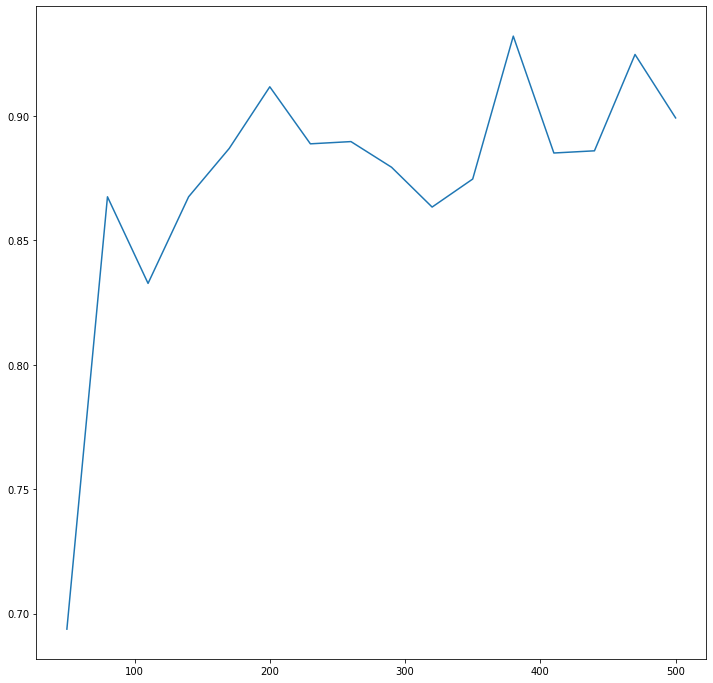

In [31]:
plt.figure(figsize=(12, 12))
plt.plot(train_num, list(map(lambda x: x[1],scores)))

In [13]:
def get_feature_names(names):
    feature_names = names.copy()
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_prev_' + name)
    for i in range(1, 5):
        for name in names:
            feature_names.append(str(i) + '_next_' + name)
    return feature_names

In [14]:
feature_names = get_feature_names(['left', 'top', 'wigth', 'height', 
                'mean_left', 'mean_height', 'mean_width',
                'line_color', 'bold_line_color', 'avg_color', 'reg1', 'reg2',
                'reg3', 'reg4', 'reg5', 'reg6', 'reg7',
                'reg8', 'reg9', 'reg10', 'reg11',
                'end_reg1', 'end_reg2', 'end_reg3', 'end_reg4', 'end_reg5',
                'word_letters_cnt', 'line_cnt', 'word_cnt', 'mean_line_cnt',
                'mean_line_color'])

xgbfir.saveXgbFI(xgb_cmodel, feature_names=feature_names, 
                 OutputXlsxFile='fearures_importances.xlsx')

X_test [{"name": "doc_name", "entities": [{"text": "", "bbox": []}]}]

In [15]:
X_train, X_test = X[:500], X[500:]

d = {}
i = 0
for doc_info in X_test:
    for line_info in doc_info['entities']:
        d[(tuple(line_info['bbox']), doc_info['name'], line_info["text"])] = [y_test[i], y_pred[i]]
        i += 1

In [17]:
color_dict = {
    1 : (0, 0, 255),
    2 : (0, 255, 0),
    3 : (255, 0, 0),
    4 : (0, 255, 255)
}
class2label = {
    1: "header", 
    2: "list", 
    3: "text", 
    4: "other"
}

grouped_by_dock = defaultdict(list)
for item in d.items():
    key, (real_class, predicted_class) = item
    file_name = key[1]
    grouped_by_dock[file_name].append(item)


for file_name, items in tqdm(grouped_by_dock.items()):
    
    img = None 
    for key, (real_class, predicted_class) in items:        
        if real_class != predicted_class:
            print(key[2])
            print()
            if img is None:
                img = cv2.imread('docs/' + file_name)
            (x, y, w, h) = key[0]
            cv2.rectangle(img, (x, y), (x + w, y + h), color_dict[predicted_class], 2)
            cv2.putText(img, class2label[predicted_class] + " " + class2label[real_class], 
                        (x, y - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, 
                        color_dict[predicted_class], 2)
    if img is not None:
        cv2.imwrite('different_docs/' + file_name, img)        

/Users/anastasiabogatenkova/miniconda3/envs/doc-py37/lib/python3.7/site-packages/ipykernel_launcher.py:21: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


10кВ рубящего или качающегося типа. Все стальные части разъединителя, в том

2.12. Особые условия:

2.12.4.

2.13. Подрядчик после окончания строительно-монтажных и пусконаладочных работ

представляет следующую документацию:

2.13.4. Акты освидетельствования скрытых работ;

1.6. Особые условия.

cook

SA

3.4. Вывод о достоверности или недостоверности определения сметной стоимости строительства,

1 Терел ивать и разливать химические вещества следует соблюдая

Ж.5.5.2 Воздушно-пенные огнетушители не должны применяться для:

мерами;

сечение и тип провода;

® Оценка Заявок на участие в запросе предложений по критерию «Сроки поставки товара,



суммирование данных no с записью полученных давных в памяти слотемы;



(решения по установке и конфигурированию программных и анпаратных средств и

Экземпляр АО «СНК»

Просим вернуть по адресу:

693004, г. Южно-Сахалинск,

«Заказчик», в лице генерального директора Дойникова Юрия Андреевича, действующего на


